## RSBench
A mini-app to represent the multipole resonance representation lookup
cross section algorithm.  
  
  ---
clang++-5.0.1 -std=gnu99 -fopenmp -ffast-math -march=native-g -Ofast  
  
Exec Line:  
./rsbench

(**Haswell**) Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz  

`divsd`: 10-20 Cycles  
`mulsd`: 5 Cycles  
`movsd`: 3 Cycles  
L1 Cache: 32 kB, 8 way, 64 sets, 64 B line size, **latency 4**, per core.    
L2 Cache: 256 kB, 8 way, 512 sets, 64 B line size, **latency 12**, per core.  
Data from Agner

| Empirical Roofline Toolkit | L1 Cache | L2 Cache | L3 Cache | DRAM |
|:---|:------:|:--------:|:----------:|:-----|
|Cache Lines / Cycle | .9715 | .3050 | 0.2188 | 0.1067 |

---
### RSBench spends around 50% of CPUTIME in libm
| Math Call | CPUTIME|
|:----|:---:|
| `__ieee754_hypot `| 16.8%  |
  |`__sin_avx`| 10.3%  
  | `__atan_avx`| 10.4%  
  | `__cos_avx`| 5.7  
  | `__hypot`| 3.5%  |
  |`__sincos`| 1.3%|

#### calculate_micro_xs_dopper( ) | Loop at line 181
calculate_micro_xs_doppler( ) calls calculate_sig_T then calls fast_nuclear_W( ) in loop.

|`for ( ) : Line 181`|  CPUTIME  | Inst per Cycle | L1 DC Miss % |  L1 Loads/Cycle |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 12.3% | 0.66 | 1.4% | 0.33 |
|**72 Thread Run** | 10.3% | 1.28 | 4.4% | 1.67 |
```c
	// Loop over Poles within window, add contributions                 
|181|	for( int i = w.start; i < w.end; i++ )                      
|182|   {
|183|	    Pole pole = data.poles[nuc][i];                              
|184|
|185|	    // Prep Z
|186|	    double complex Z = (E - pole.MP_EA) * dopp;
|187|	    if( cabs(Z) < 6.0 )
|188|		    (*abrarov)++;
|189|	    (*alls)++;
|190|
|191|	    // Evaluate Fadeeva Function
|192|	    complex double faddeeva = fast_nuclear_W( Z );
|193|
|194|	    // Update W
|195|	    sigT += creal( pole.MP_RT * faddeeva * sigTfactors[pole.l_value] );
|196|	    sigA += creal( pole.MP_RA * faddeeva);
|197|	    sigF += creal( pole.MP_RF * faddeeva);
|198|   }
```

---

#### calculate_sig_T (Time spent in libm)

|`calculate_sig_T`|  CPUTIME  | Inst per Cycle | L1 DC Miss % |  L1 Loads/Cycle |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 29.7%(I) | 1.18 | 0.5% | 0.57 |
|**72 Thread Run** | 27.0%(I) | 1.82 | 2.5% | 1.09 |
```c
|208|void calculate_sig_T( int nuc, double E, Input input, CalcDataPtrs data, complex double * sigTfactors )
|209|{
|210|	double phi;
|211|
|212|	for( int i = 0; i < input.numL; i++ )
|213|	{
|214|		phi = data.pseudo_K0RS[nuc][i] * sqrt(E);
|215|
|216|		if( i == 1 )
|217|			phi -= - atan( phi );
|218|		else if( i == 2 )
|219|			phi -= atan( 3.0 * phi / (3.0 - phi*phi));
|220|		else if( i == 3 )
|221|			phi -= atan(phi*(15.0-phi*phi)/(15.0-6.0*phi*phi));
|222|
|223|		phi *= 2.0;
|224|
|225|		sigTfactors[i] = cos(phi) - sin(phi) * _Complex_I;
|226|	}
|227|}
```

---
#### fast_nuclear_W
"This function uses a combination of the Abrarov Approximation
and the QUICK_W three term asymptotic expansion.
Only expected to use Abrarov ~0.5% of the time."
  
Function defines several hard coded values and spends most time on line 72:

|`Line 72`|  CPUTIME  | Inst per Cycle | L1 DC Miss % |  L1 Loads/Cycle |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 7.4% | 0.64| 6.1% | 0.1 |
|**72 Thread Run** | 4.0% | 0.41 | 2.9% | < 0.1 | 
```c
|72| double complex W = I * Z * (a/(Z*Z - b) + c/(Z*Z - d));  
```

---
### Strong Scaling 

In [2]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

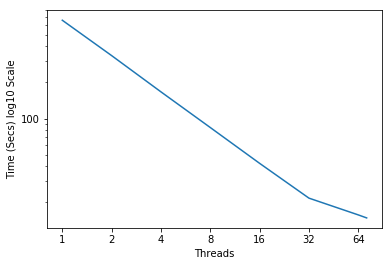

In [3]:

fig,ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)
ax.set_xlabel('Threads')
ax.set_ylabel('Time (Secs) log10 Scale')
ax.set_xticks([1,2,4,8,16,32,64])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([100, 1000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.plot([1,2,4,8,16,32,64,72], [661.467, 335.291, 167.043, 84.171, 42.287, 21.671, 15.701, 14.817])
plt.show()